# Aim of the project


In this notebook we will be creating a regression model using the `train.csv` with the aim of predicting the saleprice of the houses given in the `test.csv` data. 

For this we need our model to have a high out of sample accuracy.

The model will consist of 
* A decision tree model
* A support vector model



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import gc

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# ignore warnings
import warnings 
warnings.filterwarnings('ignore')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Import both the datasets 
viz. `train.csv` and `test.csv` in the dataframes `df_train` and `df_test` respectively.

In [2]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check the shape of the train and test datasets.

In [3]:
print('Shape of Train set: ', df_train.shape, '\nShape of Test set: ',df_test.shape)

Shape of Train set:  (1460, 81) 
Shape of Test set:  (1459, 80)


Wait, the test data is one column short! We need to find out which.

In [4]:
# convert the index series of columns to set then find the difference
print('The column present in the train set but not in test set is :', set(df_train.columns).difference(set(df_test.columns)))

The column present in the train set but not in test set is : {'SalePrice'}


Turns out our test set does not have a SalePrice column. Which means, we are to train the model with train.csv data and then evaluate the prices for the test.csv dataset.

# Data Pre-processing

Let us first clean the train set and then we will repeat the same procedures on the test set to clean it. as well.

In [5]:
print('The shape of the train set is: ',df_train.shape, '\nThe null entries in the train set are:')

null_tr = df_train.isnull().sum().sort_values(ascending=False).to_frame('Null_entries')
null_tr = null_tr[null_tr.Null_entries > 0]
null_tr

The shape of the train set is:  (1460, 81) 
The null entries in the train set are:


,Null_entries
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [6]:
# Find the columns with at least half of their entries as null of null entries
num_nulls = null_tr[null_tr.Null_entries>= df_train.shape[0]/2].count().values[0]
print(f'There are {num_nulls} columns with more than half entries as Null entries')
del num_nulls

There are 5 columns with more than half entries as Null entries


 The first 5 columns we see above are the only ones to have more than half of the data as null values. We have total of 81 cloumns so dropping the columns filled with null values should not have any effect on the analysis.

In [7]:
print('Shape of dataframe BEFORE dropping columns: ', df_train.shape)
df_train.drop(columns=df_train[null_tr.head(5).index.values], inplace=True)
print('Shape of dataframe AFTER dropping columns: ', df_train.shape)

Shape of dataframe BEFORE dropping columns:  (1460, 81)
Shape of dataframe AFTER dropping columns:  (1460, 76)


Drop the same columns from the test data (or not). You can always select only the required columns from the test set.

In [8]:
print('Shape of test data BEFORE dropping columns is: ', df_test.shape)
df_test.drop(columns=df_test[null_tr.head(5).index.values], inplace=True)
print('Shape of test data AFTER dropping columns is: ', df_test.shape)

Shape of test data BEFORE dropping columns is:  (1459, 80)
Shape of test data AFTER dropping columns is:  (1459, 75)


We have successfully dropped top 5 columns from the test set. But what about the next 5 columns? Even though there are 650+ null values in the `FireplaceQu` column, it is not certain that the column is not useful for us. We can leave that as is for now and analyse it deeply as we move forward. Further columns see a drastic drop of null values which is a good sign.

In [9]:
# negative index removes the last 5 entries which in this case are the first 5 rows since tail gives a bottom up sequence.
# it is a better alternative to deleting sometimes
# DO NOT RUN MULTIPLE TIMES
null_tr = null_tr.tail(-5)
null_tr.head(10)

,Null_entries
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81
GarageQual,81
BsmtFinType2,38
BsmtExposure,38
BsmtQual,37


***NOTE:*** The above cell reduces top 5 columns on every run, so be clear to not run it twice

## Find significant columns

### Numerical Columns

Following are the columns and their correlation coefficients with the column "SalePrice" (in descending order):


<Axes: >

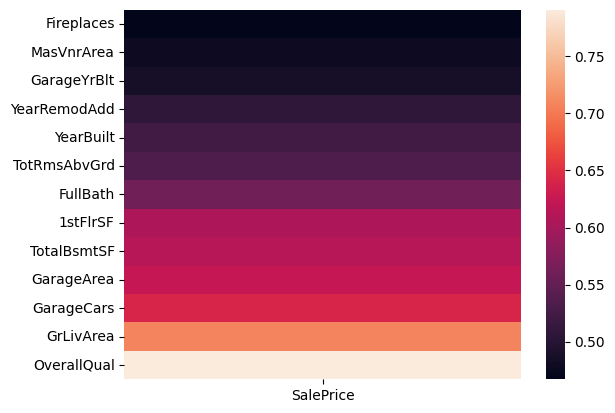

In [10]:
# Correlation of different columns with the 'SaleProce' column
# Select only the columns with a correlatioin coefficient greater than 0.4 or less than -0.3
num_corr = df_train.select_dtypes('number').corr()
sale_corr = num_corr[(num_corr>=0.4) | (num_corr<= -0.3)]
sale_corr = sale_corr[['SalePrice']].fillna(0).sort_values(by='SalePrice')
del num_corr
gc.collect()

# drop the SalePrice from the correlation dataframe
sale_corr = sale_corr[sale_corr.SalePrice != 0].drop('SalePrice', axis=0)

print('Following are the columns and their correlation coefficients with the column "SalePrice" (in descending order):')
sns.heatmap(sale_corr)

These are all the columns with significant positive or negative correlation with the 'SalePrice' column and hence must make a significant contribution in deciding the house prices. We do not see any negative correlation coefficients pointing towards the fact that increase in any of the numerical values does not affect the proce of the house negatively.

### Extract the significant numerical columns.

In [11]:
df_num = df_train[sale_corr.index]
df_num.head()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,0,196.0,2003.0,2003,2003,8,2,856,856,548,2,1710,7
1,1,0.0,1976.0,1976,1976,6,2,1262,1262,460,2,1262,6
2,1,162.0,2001.0,2002,2001,6,2,920,920,608,2,1786,7
3,1,0.0,1998.0,1970,1915,7,1,961,756,642,3,1717,7
4,1,350.0,2000.0,2000,2000,9,2,1145,1145,836,3,2198,8


## Catagorical data

For the simplicity of the model we will be focusing only on the columns with *less than or equal to 5* catagories.

In [12]:
# select column names and the number of uique elements in them
# Note that the index of the 'uniq' dataframe will be the column names

uniq = df_train.select_dtypes('object').apply(lambda x: x.unique()
                                             ).apply(lambda x: len(x)
                                                    ).sort_values().to_frame('unique_vals')

#-> In the first apply() function we select the columns and find the list of unique elements
#-> In the second apply() function we take those lists and find their lengths i.e. number of unique elements in the respective column

uniq.head()

,unique_vals
Street,2
Utilities,2
CentralAir,2
LandSlope,3
PavedDrive,3


In [13]:
# coumns with less than 5 catagories (less than 5 unique entries)
df_cat5 = df_train[ uniq[ uniq.unique_vals <= 5 ].index ]

# Add the SalePrice column in the catagorical data 
df_cat5 = df_cat5.join(df_train.SalePrice)
df_cat5.head()

,Street,Utilities,CentralAir,LandSlope,PavedDrive,GarageFinish,LotShape,LandContour,ExterQual,KitchenQual,BsmtCond,BsmtQual,HeatingQC,ExterCond,MSZoning,BsmtExposure,BldgType,LotConfig,SalePrice
0,Pave,AllPub,Y,Gtl,Y,RFn,Reg,Lvl,Gd,Gd,TA,Gd,Ex,TA,RL,No,1Fam,Inside,208500
1,Pave,AllPub,Y,Gtl,Y,RFn,Reg,Lvl,TA,TA,TA,Gd,Ex,TA,RL,Gd,1Fam,FR2,181500
2,Pave,AllPub,Y,Gtl,Y,RFn,IR1,Lvl,Gd,Gd,TA,Gd,Ex,TA,RL,Mn,1Fam,Inside,223500
3,Pave,AllPub,Y,Gtl,Y,Unf,IR1,Lvl,TA,Gd,Gd,TA,Gd,TA,RL,No,1Fam,Corner,140000
4,Pave,AllPub,Y,Gtl,Y,RFn,IR1,Lvl,Gd,Gd,TA,Gd,Ex,TA,RL,Av,1Fam,FR2,250000


In [14]:
# Check how many null values are present in the <columns with less than or equal to 5 catagories>
print('Shape of df_cat5 : ',df_cat5.shape)
df_cat5.isnull().sum().sort_values(ascending=False).to_frame('Null entries').head()

Shape of df_cat5 :  (1460, 19)


,Null entries
GarageFinish,81
BsmtExposure,38
BsmtCond,37
BsmtQual,37
Street,0


Only **4** of the desired columns have null values ranging from 37 to 81 as in previous scenario with numerical values. since SalePrice column does not have a ny null values let us simply drop these Null values.

In [15]:
df_cat5.dropna(inplace=True)
df_cat5.shape

(1348, 19)

Successfully dropped the null rows.

In [16]:
# see the value counts for all the columns
[print(df_cat5.columns[i],'\t',df_cat5[df_cat5.columns[i]].value_counts().index.values, df_cat5[df_cat5.columns[i]].value_counts().values ) for i in range(0, df_cat5.shape[1]-1)]!=None

Street 	 ['Pave' 'Grvl'] [1343    5]
Utilities 	 ['AllPub' 'NoSeWa'] [1347    1]
CentralAir 	 ['Y' 'N'] [1287   61]
LandSlope 	 ['Gtl' 'Mod' 'Sev'] [1275   61   12]
PavedDrive 	 ['Y' 'N' 'P'] [1267   54   27]
GarageFinish 	 ['Unf' 'RFn' 'Fin'] [580 418 350]
LotShape 	 ['Reg' 'IR1' 'IR2' 'IR3'] [836 462  40  10]
LandContour 	 ['Lvl' 'Bnk' 'HLS' 'Low'] [1216   52   48   32]
ExterQual 	 ['TA' 'Gd' 'Ex' 'Fa'] [804 485  52   7]
KitchenQual 	 ['TA' 'Gd' 'Ex' 'Fa'] [651 576  98  23]
BsmtCond 	 ['TA' 'Gd' 'Fa' 'Po'] [1246   63   38    1]
BsmtQual 	 ['Gd' 'TA' 'Ex' 'Fa'] [600 595 121  32]
HeatingQC 	 ['Ex' 'TA' 'Gd' 'Fa' 'Po'] [712 381 218  36   1]
ExterCond 	 ['TA' 'Gd' 'Fa' 'Ex'] [1193  137   16    2]
MSZoning 	 ['RL' 'RM' 'FV' 'RH' 'C (all)'] [1073  191   65   11    8]
BsmtExposure 	 ['No' 'Av' 'Gd' 'Mn'] [896 213 128 111]
BldgType 	 ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon'] [1147  113   38   28   22]
LotConfig 	 ['Inside' 'Corner' 'CulDSac' 'FR2' 'FR3'] [965 245  91  43   4]


True

Take a more detailed look into them.

In [17]:
[print(df_cat5.groupby(by=df_cat5.columns[i] ).agg(['count', sum, min, max])['SalePrice'],'\n') for i in range(0, df_cat5.shape[1]-1)]!=None

        count        sum    min     max
Street                                 
Grvl        5     662643  55993  228950
Pave     1343  251567996  35311  755000 

           count        sum     min     max
Utilities                                  
AllPub      1347  252093139   35311  755000
NoSeWa         1     137500  137500  137500 

            count        sum    min     max
CentralAir                                 
N              61    6994437  35311  265979
Y            1287  245236202  60000  755000 

           count        sum     min     max
LandSlope                                  
Gtl         1275  237141790   35311  755000
Mod           61   12492919   55993  538000
Sev           12    2595930  108480  375000 

            count        sum    min     max
PavedDrive                                 
N              54    6940439  40000  265979
P              27    3613900  79500  215000
Y            1267  241676300  35311  755000 

              count       sum    min  

True

First 5 columns do not have enough spread through the different values and will not be very useful in determining the price. Furthermore, the `LandContour`, `BsmtCond`, ExterCond 	 , MSZoning 	 

In order to use these objective columns we first need to convert them to numerical type data. We will use `LabelEncoder` to do that.

In [18]:
# Create a list of encoders for each column
LE = [LabelEncoder() for i in range(0,df_cat5.shape[1])]

# Fit the elements of each columns - use unique elements only
[LE[i].fit(df_cat5[df_cat5.columns[i]].unique()) for i in range(0, df_cat5.shape[1])]
print('A list of label encoders has been created and have been fitted with all the columns of the catagorical data less than 5 unique elements.')

A list of label encoders has been created and have been fitted with all the columns of the catagorical data less than 5 unique elements.


Crerating seperate encoding objects for different columns helps us inverse transform the dataset if needed.

Check the classes of the encoders created above.

Now all the columns have been fitted in their respective encoders. 

Transform the columns by iterating through the columns.


In [19]:
for i in range(0, df_cat5.shape[1]-1):
    df_cat5[df_cat5.columns[i]] = LE[i].transform(df_cat5[df_cat5.columns[i]])
print('Transformation is complete')

Transformation is complete


***NOTE:*** Do NOT run it multiple times.

In [20]:
set(df_num.columns).intersection(set(df_cat5.columns))

set()

In [21]:
df = df_num.join(df_cat5, lsuffix='',rsuffix='', how='left')
df.head()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,...,KitchenQual,BsmtCond,BsmtQual,HeatingQC,ExterCond,MSZoning,BsmtExposure,BldgType,LotConfig,SalePrice
0,0,196.0,2003.0,2003,2003,8,2,856,856,548,...,2.0,3.0,2.0,0.0,3.0,3.0,3.0,0.0,4.0,208500.0
1,1,0.0,1976.0,1976,1976,6,2,1262,1262,460,...,3.0,3.0,2.0,0.0,3.0,3.0,1.0,0.0,2.0,181500.0
2,1,162.0,2001.0,2002,2001,6,2,920,920,608,...,2.0,3.0,2.0,0.0,3.0,3.0,2.0,0.0,4.0,223500.0
3,1,0.0,1998.0,1970,1915,7,1,961,756,642,...,2.0,1.0,3.0,2.0,3.0,3.0,3.0,0.0,0.0,140000.0
4,1,350.0,2000.0,2000,2000,9,2,1145,1145,836,...,2.0,3.0,2.0,0.0,3.0,3.0,0.0,0.0,2.0,250000.0


In [22]:
df_cat5.Utilities.value_counts()

Utilities
0    1347
1       1
Name: count, dtype: int64

# Selecting data for the model

In [23]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenP

In [24]:
data = df_train[sale_corr.index.values]
data = data.join(df_train['SalePrice'], lsuffix='', rsuffix='')
data.head()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,SalePrice
0,0,196.0,2003.0,2003,2003,8,2,856,856,548,2,1710,7,208500
1,1,0.0,1976.0,1976,1976,6,2,1262,1262,460,2,1262,6,181500
2,1,162.0,2001.0,2002,2001,6,2,920,920,608,2,1786,7,223500
3,1,0.0,1998.0,1970,1915,7,1,961,756,642,3,1717,7,140000
4,1,350.0,2000.0,2000,2000,9,2,1145,1145,836,3,2198,8,250000


In [25]:
data.shape

(1460, 14)

In [26]:
data.isnull().sum()

Fireplaces       0
MasVnrArea       8
GarageYrBlt     81
YearRemodAdd     0
YearBuilt        0
TotRmsAbvGrd     0
FullBath         0
1stFlrSF         0
TotalBsmtSF      0
GarageArea       0
GarageCars       0
GrLivArea        0
OverallQual      0
SalePrice        0
dtype: int64

We cannot have a column with Null values so we will drop theserows now. Since we have a large dataset it will not make much difference. On the other hand we can choose not to use these columns instead.

In [27]:
data.dropna(inplace=True)
print(data.shape)
data.isnull().sum()

(1371, 14)


Fireplaces      0
MasVnrArea      0
GarageYrBlt     0
YearRemodAdd    0
YearBuilt       0
TotRmsAbvGrd    0
FullBath        0
1stFlrSF        0
TotalBsmtSF     0
GarageArea      0
GarageCars      0
GrLivArea       0
OverallQual     0
SalePrice       0
dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), data['SalePrice'], test_size=0.4, random_state=4)

In [29]:
print('X_train: ',X_train.shape, '\ny_train: ', y_train.shape, '\nX_test: ', X_test.shape,'\ny_test: ', y_test.shape)

X_train:  (822, 13) 
y_train:  (822,) 
X_test:  (549, 13) 
y_test:  (549,)


# Create Regression Tree

In [30]:
reg_tree = DecisionTreeRegressor(criterion='absolute_error', splitter='best', random_state=1, max_depth=4)
reg_tree

DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=1)

# Training

In [31]:
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=1)

# Evaluation

In [32]:
print('R^2 value of the model is: ',round(reg_tree.score(X_test, y_test), 4))

R^2 value of the model is:  0.7304


In [33]:
prediction = reg_tree.predict(X_test)
prediction[0:5]

array([151000., 109500., 119100., 186200., 130000.])

In [34]:
print('Mean absolute error is $', (prediction -y_test).abs().mean())

Mean absolute error is $ 26399.589253187612


## Visualize the regression tree

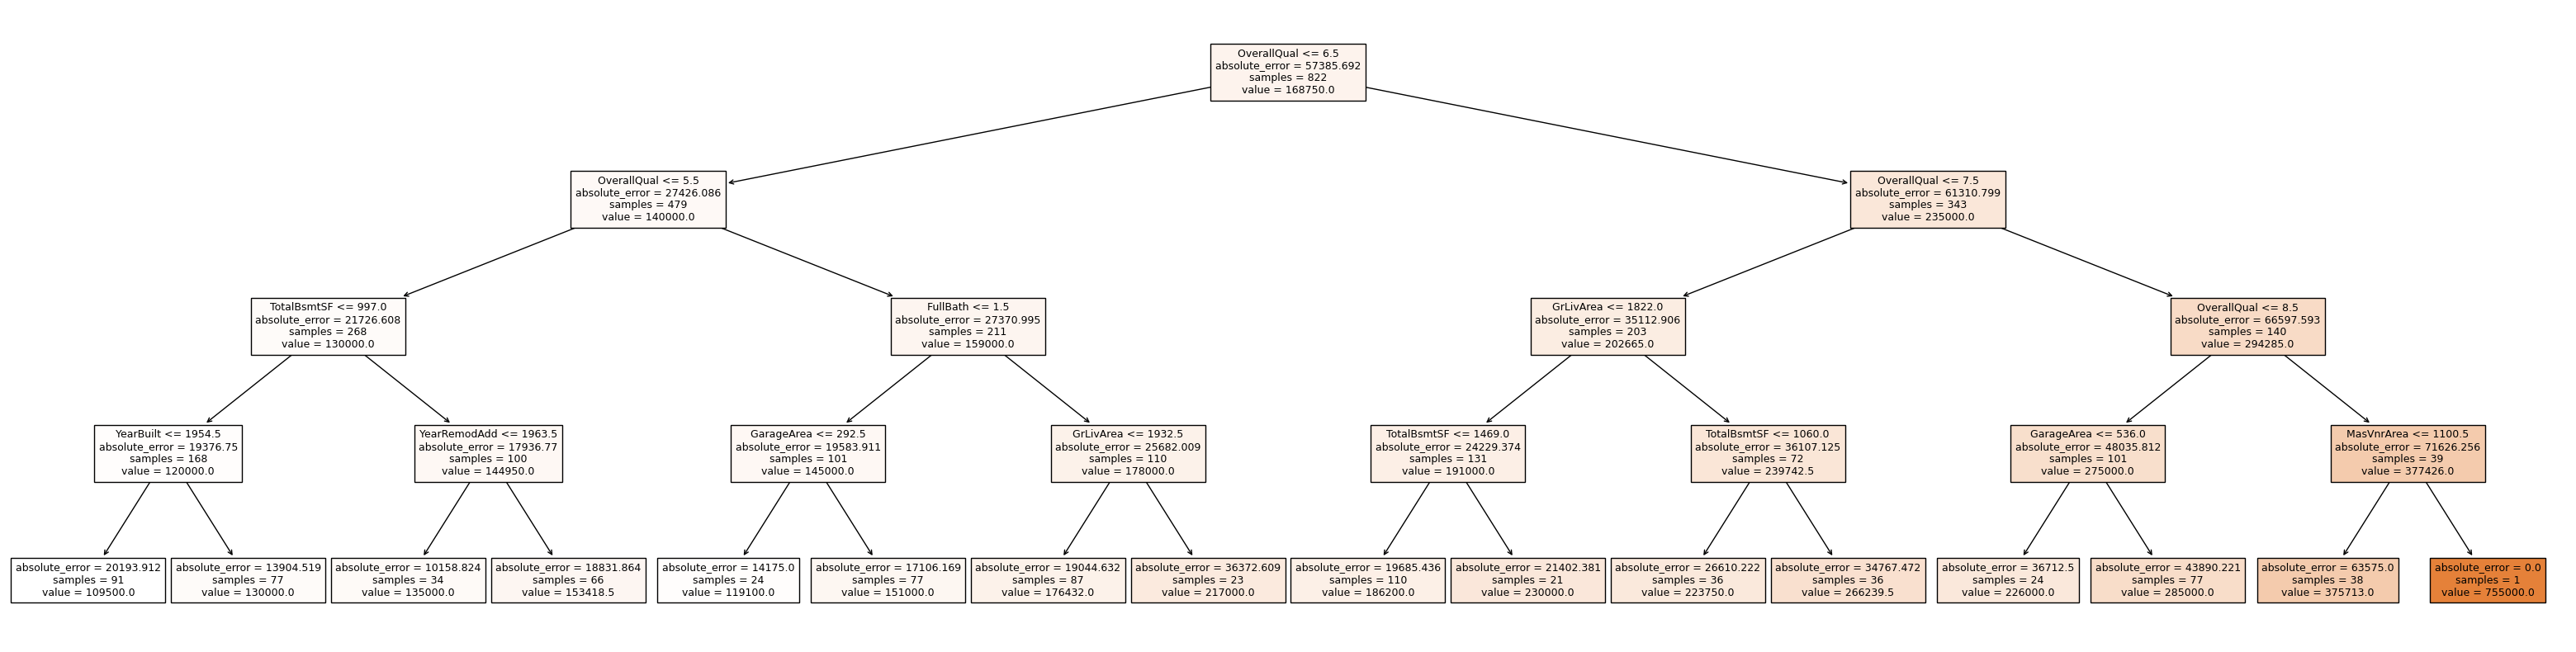

In [35]:
from sklearn import tree

plt.figure(figsize=(40,10))
tree.plot_tree(reg_tree, feature_names=X_train.columns.values,
               filled=True, precision=3, fontsize=9)
plt.show()

# Find the values for the test data

In [36]:
cols = list(X_train.columns.values)
cols.insert(0, 'Id')
cols

['Id',
 'Fireplaces',
 'MasVnrArea',
 'GarageYrBlt',
 'YearRemodAdd',
 'YearBuilt',
 'TotRmsAbvGrd',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'OverallQual']

In [37]:
submission_df = df_test[cols].dropna()

In [38]:
yhat= reg_tree.predict(submission_df.drop(columns='Id'))
yhat

array([130000. , 151000. , 130000. , ..., 130000. , 153418.5, 223750. ])

In [39]:
submission_df = submission_df.join(pd.Series(yhat).to_frame('SalePrice_pred'), 
                                   lsuffix='',rsuffix='')

In [40]:
submission_df[['Id', 'SalePrice_pred']].head()

,Id,SalePrice_pred
0,1461,130000.0
1,1462,151000.0
2,1463,130000.0
3,1464,176432.0
4,1465,226000.0


In [41]:
submission_df.to_csv('test_presd_submission.csv')